In [12]:
from __future__ import print_function
import argparse
import os
import time
import random
import numpy
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torch.utils.data import DataLoader
from IPython.display import HTML
from torchvision import utils, datasets, transforms
import pandas as pd
#import xlrd
from math import sqrt
from PIL import Image


In [27]:
xlsx_path="/content"
model_path="/content/model-final.pt"
result_path="/content/results"

In [14]:

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.image = nn.Sequential(
            # input is nz, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
        )
        self.prior = nn.Sequential(
            # state size. 1 x 1 x 1
            nn.ConvTranspose2d(1, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True)
            # state size. (ngf*8) x 4 x 4
        )
        self.main = nn.Sequential(
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf * 2) x 32 x 32
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, image, prior):
        image = self.image(image)
        prior = self.prior(prior)
        #Stitch two tensors (image, prior) together, dim=1 means splicing according to dimension 1 (column), side by side
        incat = torch.cat((image, prior), dim=1)
        return self.main(incat)

def tensor_to_np(tensor):
  img = tensor.cpu().clone()
  #img = img.cpu().numpy().squeeze(0).transpose((1, 2, 0))
  img = img.numpy().transpose((1, 2, 0))
  unloader = transforms.ToPILImage()
  img = unloader(img)
  #print(img)
  return img

def tensor_to_PIL(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    return image

In [46]:

image_size = 128
workers = 8
ngpu = 1
nz = 5
ngf = 64
nc = 1
#  data_valid = "data/ValidationDB"
#  dataset_valid = dset.ImageFolder(root=data_valid,
#                             transform=transforms.Compose([
#                               transforms.Grayscale(num_output_channels=1),
#                               transforms.ToTensor(),
#                               transforms.Normalize((0.5), (0.5)),
#                             ]))
#  print(f'Total Size of Dataset for Test: {len(dataset_valid)}')
# dataloader_valid = torch.utils.data.DataLoader(dataset=dataset_valid, batch_size=valid_num, shuffle=True, num_workers=workers)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("device to run on is", device)


############################
# Read the Condition Number
############################
valid_label = []                              #Condition Number Tensor (daynum*1*1*1)  future days/1 dimension/1*1 pix
#Read the Condition Number from xlsx file
df = pd.read_excel(xlsx_path+"/results2.xlsx", sheet_name="Sheet", header=0, usecols=[1])   # "Need Change" It is for reading the conditional numbers stored in thexlsx file. Please note that the 2nd clos is 1, the 3rd clos is 2,et.al.
df1 = pd.read_excel(xlsx_path+"/results2.xlsx", sheet_name="Sheet", header=0, usecols=[0])  # "Need Change" It is for reading the file names in the 1st clos in the
df_li = df.values.tolist()    #Change the read table into an array
df_li1 = df1.values.tolist()  #read date e.g. 2025-01-01
data_downscaled = []
date_list = []
for s_li in df_li:
    data_downscaled.append(s_li[0])
for s_li1 in df_li1:
    date_list.append(s_li1[0])
date_size = len(data_downscaled)	#Calculate the number of days.
print("date_size is", date_size)
valid_label_ones = torch.ones(date_size, 1, 1, 1).to(device)
for m in range(date_size):
    valid_label_ones[m]=valid_label_ones[m]* data_downscaled[m]#*0.5+0.5)*100-50+273
valid_label = valid_label_ones.to(device)
print("The tensor of condition number have been created.")

############################
# downscaling
############################

# Set uncertainty analysis number
uncertainty_num = 512      # "Need Change"
downscaled_result = torch.zeros(date_size,image_size,image_size)
downscaled_std = torch.zeros(date_size,image_size,image_size)

validation_list = torch.zeros(date_size,uncertainty_num,image_size,image_size)

# Load trained model
netG = Generator(0).to(device)
netG.load_state_dict(torch.load(model_path, map_location=device))
netG.eval()
print("Begin to downscaled, this may take a long time depends on how many days need to be downscaled")
stat_time = float(time.time())
for d in range(date_size):   # calculating day by day
  #print("Begin downscaled data:", d)
  downscaled_list = torch.zeros(uncertainty_num,image_size,image_size)  #For each day, a scratchpad for the calculation results of multiple iterations
  for i in range(uncertainty_num):
    manualSeed = 1 + i
    #print("Random Seed: ", manualSeed)
    random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.cuda.manual_seed(manualSeed)
  #For the same manualSeed, the numbers randomly generated by torch.rand in this code sequence are fixed in this program (note: the numbers are different if you write the same sentence again)
    noise_valid = torch.randn(1, nz, 1, 1, device=device)  #[num, channel, height, width]   Each seed number iteratively samples a 10*1*1 noise
    #netG = Generator(0).to(device)
    #netG.load_state_dict(torch.load('model-final.pt', map_location=device))
    #netG.eval()
    # Generate the Fake Images
    valid_label_j = torch.zeros(1, 1, 1, 1, device=device)
    valid_label_j[0] = valid_label[d]    #Make the condition numbers into a 4-dimensional Tensor
    with torch.no_grad():
        validation = netG(noise_valid, valid_label_j).detach().cpu()    #Here, we cannot make all the days into one tensor, because this will cause a huge network leanding to GPU out of memory
        validation_list[d][i]=validation
    #torch.cuda.empty_cache()
    #downscaled_list[i] = (validation[0][0]*0.5+0.5)*100-50+273
    downscaled_list[i] = (validation[0][0]*0.5+0.5)*255 #[0,255]
    downscaled_result[d] = downscaled_result[d] + (downscaled_list[i]/uncertainty_num)  #In the iterative process of uncertainty analysis, the mean value is accumulated


    #downscaled_output_single = torch.zeros(1,image_size,image_size)
    #downscaled_output_single[0] = downscaled_result[d]
    #image_single = tensor_to_np(downscaled_output_single)
    #image_single.save(r"C:\Users\fedeb\OneDrive\Desktop\Supplementary Material\ProvaDownscaling\results//"+ date_list[d]+'_'+str(i)+'_'+ "_result.tif")


  downscaled_output = torch.zeros(1,image_size,image_size)
  downscaled_output1 = torch.zeros(1,image_size,image_size)
  downscaled_output[0] = downscaled_result[d]
  image = downscaled_output.numpy()
  #print("Finish result data:", d)
  #image.save(result_path+'/'+ date_list[d] + "_result.tif")
  im = Image.fromarray(image[0])
  im.save(result_path+'/'+ date_list[d][:date_list[d].rfind(".tiff")] + "_result.tif")
  #print("Finish result data:", d)
  #image.save(result_path+'/'+ date_list[d][:date_list[d].rfind(".tiff")] + "_result.tif")  # "Need Change" Please change "results//" here to the folder name you want to store the outputs.
  #Calculation uncertainty
  for i in range(uncertainty_num):
    downscaled_std[d] = downscaled_std[d] + (downscaled_list[i] - downscaled_result[d])*(downscaled_list[i] - downscaled_result[d])
  downscaled_std[d] = numpy.sqrt(downscaled_std[d])/uncertainty_num
  downscaled_output1[0] = downscaled_std[d]
  image = tensor_to_np(downscaled_output1)
  #print("Finish uncertainty data:", d)
  image.save(result_path+'/'+ date_list[d][:date_list[d].rfind(".tiff")] + "_uncertainty.tif")  # "Need Change" Please change "results//" here to the folder name you want to store the outputs.
  if (d + 1) % 365 == 0:
    end_time = float(time.time())
    print("Finish data:",date_list[d][:date_list[d].rfind(".tiff")])
    print("Used time:",(end_time-stat_time)/60,"min | Estimate left time:",(end_time-stat_time)/(d + 1)*(date_size-d-1)/3600,"hours")
print("Successful finished!")



device to run on is cuda:0
date_size is 2
The tensor of condition number have been created.
Begin to downscaled, this may take a long time depends on how many days need to be downscaled


<ipython-input-46-e4f25452cd51>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(model_path, map_location=device))


Successful finished!


In [ ]:
date_list[d][:date_list[d].rfind(".tiff")]

'image_10000'

In [ ]:
validation_list.shape

torch.Size([2, 512, 128, 128])

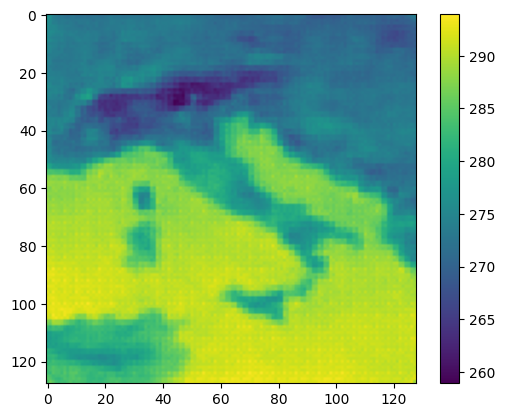

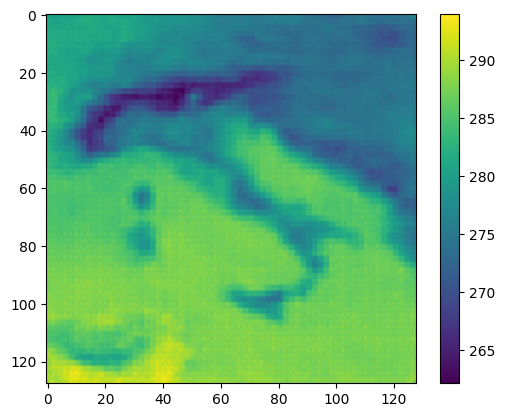

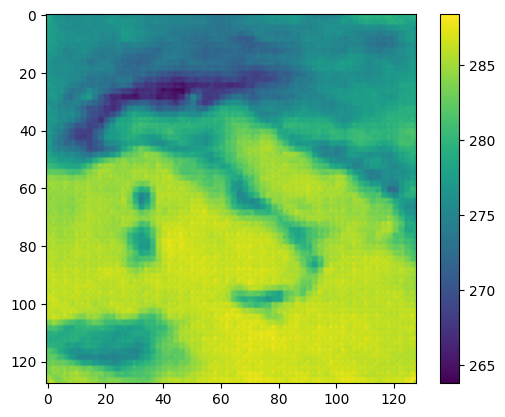

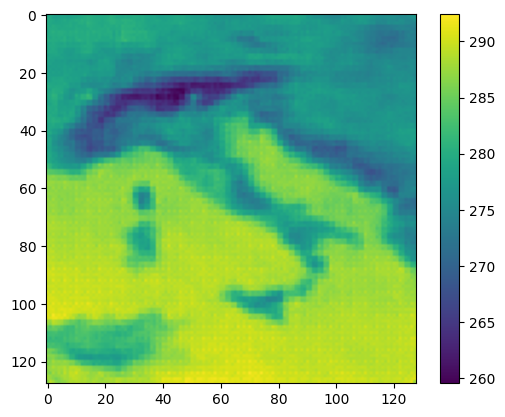

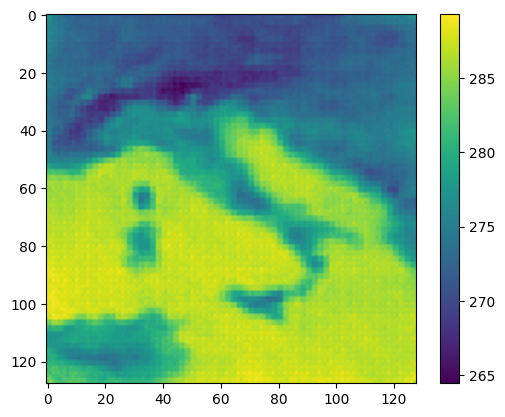

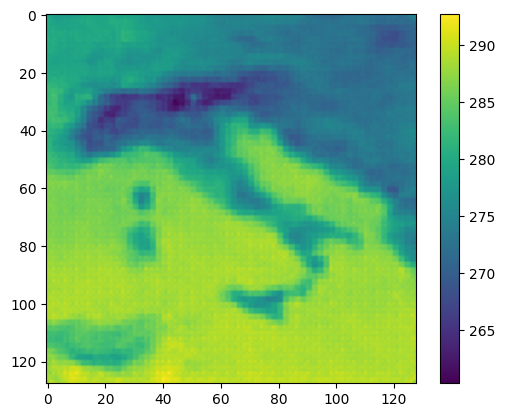

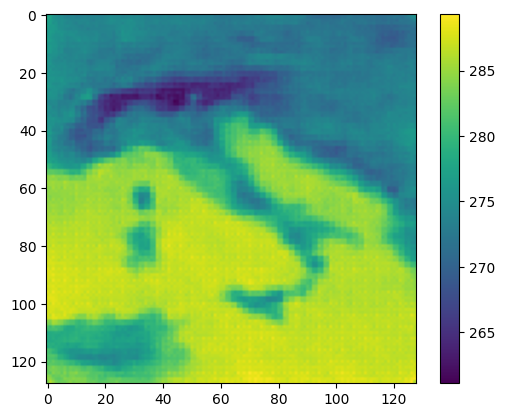

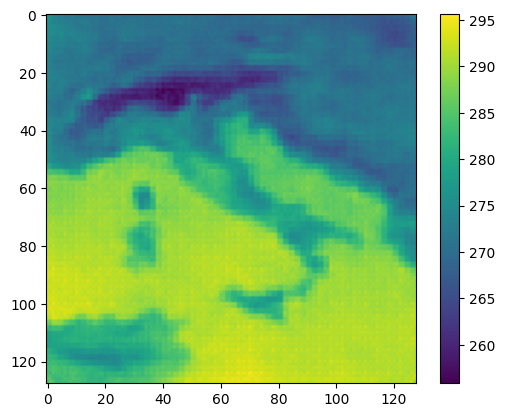

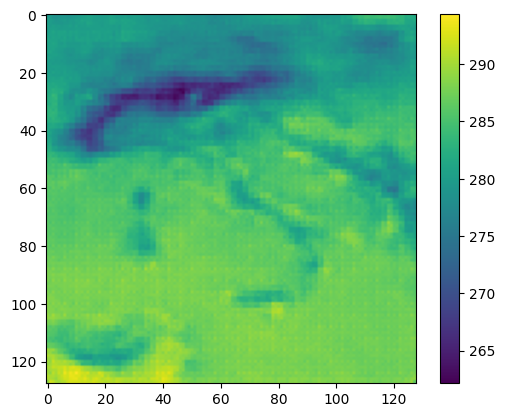

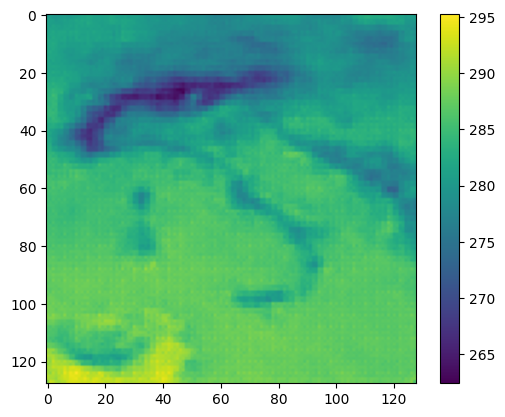

In [56]:
validation.shape
for i in range(10):
  plt.figure(i)
  plt.imshow((validation_list[1][5*i]*0.5+0.5)*100-50+273)
  plt.colorbar()

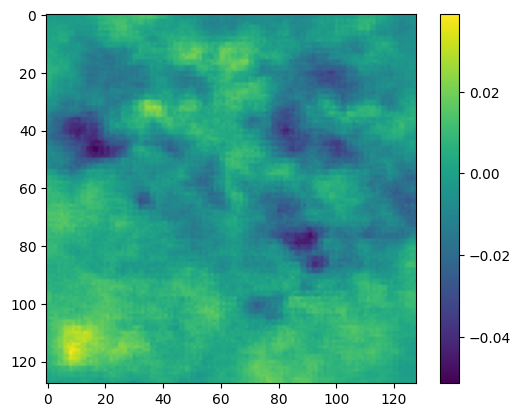

In [ ]:
plt.imshow(((validation_list[0][100]-validation_list[0][200])))
plt.colorbar()

In [ ]:
validation_list.shape

torch.Size([2, 512, 128, 128])

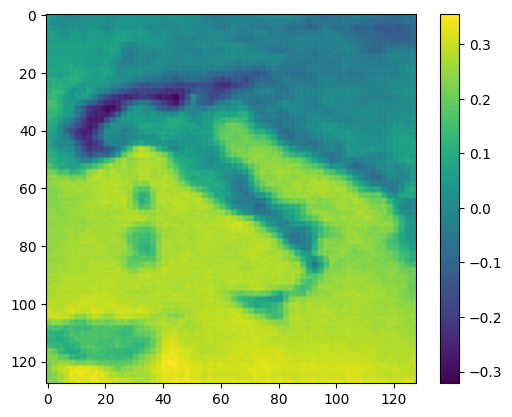

In [ ]:
img=torch.zeros(1,image_size,image_size)
for i in range(validation_list.shape[1]):
  img[0]=img[0]+validation_list[0][i]/validation_list.shape[1]

validation.shape
plt.imshow(img[0])
plt.colorbar()

downscaled_output[0] = img[0]
image = downscaled_output.numpy()
#print("Finish result data:", d)
#image.save(result_path+'/'+ date_list[d] + "_result.tif")
im = Image.fromarray(image[0])
im.save(result_path+'/'+ date_list[d] + "_result.tif")


In [ ]:
image.shape

(1, 128, 128)

In [ ]:
image[0]

array([[ 0.06350694,  0.06768051,  0.04206995, ..., -0.04539173,
        -0.04798662,  0.01909366],
       [ 0.08495907,  0.0434093 ,  0.0164288 , ..., -0.08933586,
        -0.07162305, -0.04791933],
       [ 0.06021231,  0.03674804,  0.01666345, ..., -0.06503244,
        -0.07269499, -0.05188601],
       ...,
       [ 0.22609083,  0.20001209,  0.22484323, ...,  0.28607327,
         0.29463536,  0.29213178],
       [ 0.23229623,  0.21914934,  0.23874842, ...,  0.3180866 ,
         0.30142307,  0.32064795],
       [ 0.24592155,  0.24607262,  0.22166961, ...,  0.31515145,
         0.3267336 ,  0.28154835]], dtype=float32)

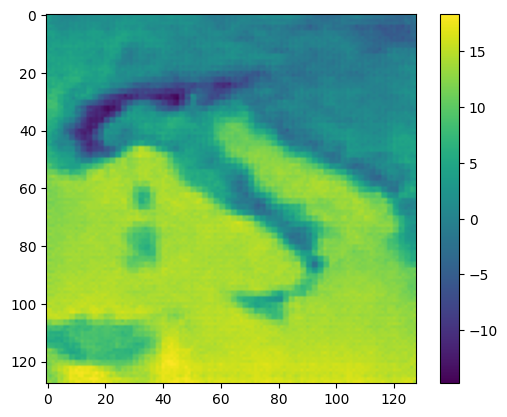

In [ ]:
validation.shape
plt.imshow(downscaled_result[d])
plt.colorbar()

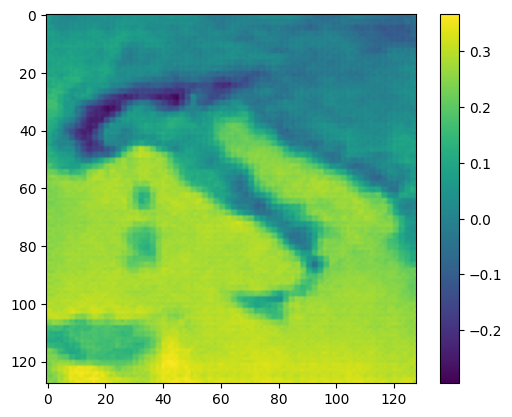

In [ ]:
validation.shape
plt.imshow(downscaled_result[d])
plt.colorbar()

In [ ]:
downscaled_list[i-100]==downscaled_list[i]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

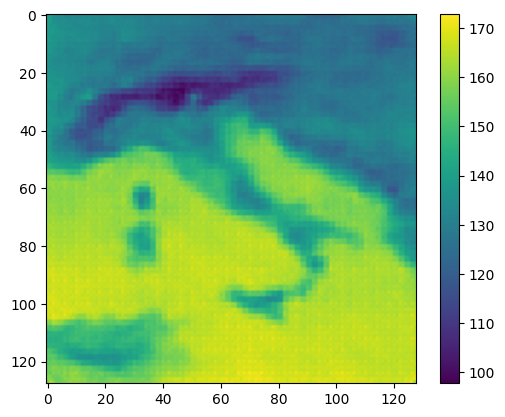

In [47]:
from PIL import Image
final=Image.open("/content/results/image_0_result.tif")
img_final= np.array(final)

plt.imshow(img_final)
plt.colorbar()

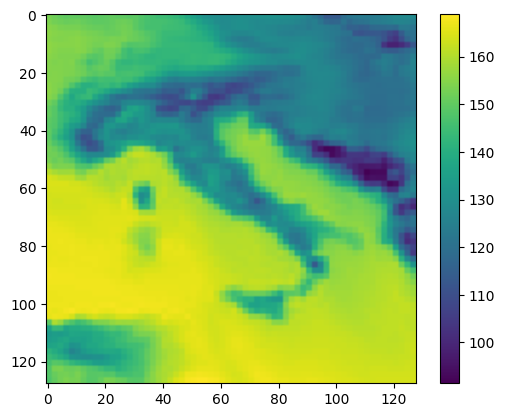

In [48]:
from PIL import Image
real=Image.open("/content/image_0.tiff")
img_real= np.array(real)

#plt.imshow((img_real)/255*100-50+273)
plt.imshow((img_real))
plt.colorbar()

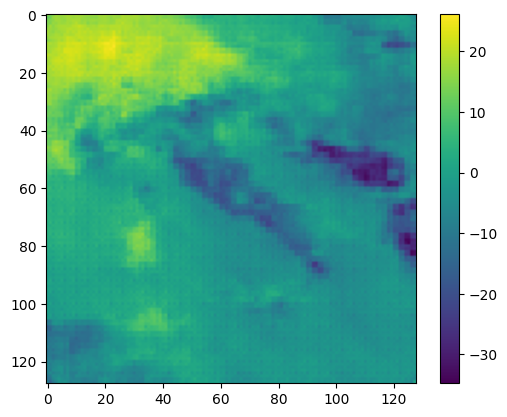

In [49]:
diff=img_real-img_final
plt.imshow(diff)
plt.colorbar()